### Hotel Review Classifier (working title)

*Flatiron School Data Science Bootcamp*

Captsone Project - NLP Sentiment/Ratings Analysis

Anna D'Angela | [annaadangela@gmail.com](annaadangela@gmail.com)

[Return to GitHub](https://github.com/anna-dang/mod05-capstone)


# TODO
- upgrade plot design
- EDA : heat map of data sources
- train/test split
- actual NLP...
- visuals: word cloud, freq dist, etc.
- baseline model 


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import pandas as pd
import numpy as np

seed = 619

import nltk
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import data and explore

In [103]:
# import test data
df_raw = pd.read_csv("./data/clean_scrape.csv")
display(df_raw.head())

# check for null/value types
df_raw.info()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Easy check in and check out process using the ...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,We needed a last-minute place to stay in Denve...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,We love Hyatt hotels and have had many great e...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,"I have never encountered such helpful, friendl...",5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,"We love it here! Great service, they usually r...",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22217 entries, 0 to 22216
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Location  22217 non-null  object
 1   Hotel     22217 non-null  object
 2   Title     22217 non-null  object
 3   Review    22217 non-null  object
 4   Rating    22217 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 868.0+ KB


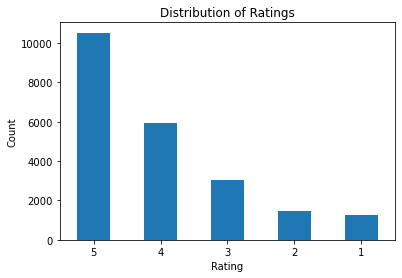

In [104]:
# Examine class distribution by count
df_raw['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

In [106]:
# Examine imbalance as percentage
percent = round(df_raw['Rating'].value_counts(1).to_frame(name='Percent %').rename_axis('Rating') * 100, 2)
percent

,Percent %
Rating,
5,47.36
4,26.66
3,13.62
2,6.69
1,5.67


There is a significant imbalance in classes. First I will randomly undersample the most major class, 5 by equalizing the amount with the second highest class, 4. This is to reduce the dimensions for the model by growing the total corpus largely positive.

In [107]:
tot_5 = df_raw[df_raw['Rating'] == 5].count()[0] 
tot_4 = df_raw[df_raw['Rating'] == 4].count()[0] 
drop_n = tot_5 - tot_4
drop_n

4600

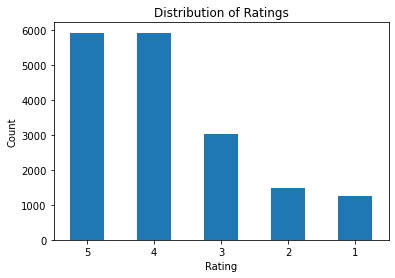

In [110]:
test = df_raw.drop(df_raw[df_raw['Rating'].eq(5)].sample(drop_n, random_state=seed).index)

# Examine class distribution by randomly reducing the most major class
test['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

Remaining class imbalance is less sever, I will address this by using class weights when modeling.

### Collection distribution

In [128]:
# Examine collection distribution by location
avg_df = df_raw.groupby(by = 'Hotel')[['Rating']].agg(['count', 'mean'])

coords = pd.read_csv("./data/coordinates.csv", names = ['Hotel', 'Lat', 'Long'])

map_df = pd.merge(avg_df, coords, on = 'Hotel')
map_df

,Hotel,"(Rating, count)","(Rating, mean)",Lat,Long
0,Baymont by Wyndham Denver International Airport,2094,3.949379,39.820740,-104.770119
1,Best Western Plus Denver International Airport...,1000,3.633000,39.824161,-104.770178
2,Clarion Hotel Denver Central,920,3.372826,39.783300,-104.990895
3,DoubleTree by Hilton Hotel Denver,2000,3.859500,39.763101,-104.904370
4,Embassy Suites by Hilton Denver International ...,1000,3.996000,39.824143,-104.775354
5,Grand Hyatt Denver Downtown,1000,4.488000,39.745762,-104.988802
6,Hilton Denver City Center,1000,4.101000,39.747159,-104.990145
7,Hyatt Place Denver/Cherry Creek,995,4.156784,39.695828,-104.938547
8,Hyatt Regency Denver At Colorado Convention Ce...,2000,4.460000,39.744213,-104.993667
9,La Quinta Inn & Suites by Wyndham Denver Airpo...,1000,3.803000,39.820897,-104.773078


In [149]:
# import plotly.express as px
# import geopandas as gpd

# map_df['text'] = (map_df['Hotel'] + '' + 'Reviews:' + 
#                   map_df[('Rating', 'count')].astype(str) + 'Rating: ' 
#                   + map_df[('Rating', 'mean')].astype(str))

# geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# #px.set_mapbox_access_token(open(".mapbox_token").read())
# fig = px.scatter_mapbox(map_df,
#                         lat='Lat',
#                         lon='Long',
#                         hover_name='text',
#                         zoom=1)
# fig.show()

ModuleNotFoundError: No module named 'geopandas'

In [143]:
# # Examine distribution by location 
# lat_foc = 39.7452
# lon_foc = -104.9922


# # Pop up text
# map_df['text'] = (map_df['Hotel'] + '' + 'Reviews:' + 
#                   map_df[('Rating', 'count')].astype(str) + 'Rating: ' 
#                   + map_df[('Rating', 'mean')].astype(str))

# fig = go.Figure(data=go.Scattergeo(
#         lon = map_df['Long'],
#         lat = map_df['Lat'],
#         text = map_df['text'],
#         mode = 'markers',
#         marker_color = map_df[('Rating', 'mean')]
#         ))

# fig.update_layout(
#         title = "Hotel's Scraped",
#         geo_scope='usa',
#         geo = dict(
#             projection_scale= 3000, #this is kind of like zoom
#             center=dict(lat=lat_foc, lon=lon_foc), showland = True,) # this will center on the point
#     )
# fig.show()

# # focus point

### Pre-processing

In [15]:
# combine 'Title' and 'Review' into one chucnk of text (seperate with a space)
df_raw['Review'] = df_raw['Title'] + ' ' + df_raw['Review']
df_raw.head()

,Location,Hotel,Title,Review,Rating
0,"Detroit, MI",The Siren Hotel,Absolute stunner in best location,Absolute stunner in best location I have staye...,5
1,"Detroit, MI",The Siren Hotel,Wonderful,Wonderful Had a great time at The Siren Hotel....,5
2,"Detroit, MI",The Siren Hotel,Beautiful hotel,Beautiful hotel The Siren hotel is located in ...,5
3,"Detroit, MI",The Siren Hotel,"5 stars, Best Detroit hotel!","5 stars, Best Detroit hotel! Had a great time ...",5
4,"Detroit, MI",The Siren Hotel,Amazing,"Amazing Great hotel,Danny at the front desk wa...",5


In [16]:
# Drop columns uneeded for this analysis, save as working df
df = df_raw.drop(columns = ['Location', 'Hotel', 'Title'])
df.head()

,Review,Rating
0,Absolute stunner in best location I have staye...,5
1,Wonderful Had a great time at The Siren Hotel....,5
2,Beautiful hotel The Siren hotel is located in ...,5
3,"5 stars, Best Detroit hotel! Had a great time ...",5
4,"Amazing Great hotel,Danny at the front desk wa...",5


### Train / Test Split
1) **Split the sample data into 3 groups**: train, validation and test, where train is used to fit the model, validation is used to evaluate fitness of interim models, and test is used to assess final model fitness.

2) **Split the sample data into 2 groups**: train and test, where train is further split into train and validation set k times using k-fold cross validation, and test is used to assess final model fitness. With k-fold cross validation:

In [25]:
# Split BEFORE processsing to avoid leaking
X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=seed)

X_train.shape, X_test.shape

# Words in test but not in train - decode_error = ignore

((1875,), (625,))

In [21]:
y_train.value_counts(1)

5    0.597867
4    0.234667
3    0.090667
2    0.042667
1    0.034133
Name: Rating, dtype: float64

### NLP Preprocessing
Transform unstructured data to a matrix of numbers. Fits to entire training data 'X_train' to build entire corpus.

#### Feature Engineering for Text Data
- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Start at baseline model, then adjust and see results.

In [ ]:
# from medium
def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stop words
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# Fit to the data and transform to feature matrix
X_train_tfidf = vectoriser.fit_transform(X_train)
X_train_tfidf.shape

In [ ]:
# cleaning - remove punctuation, captialization, regex for conjunctions
# more complex: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"


In [ ]:
# remove stops words, reduce dimensionality
from nltk.corpus import stopwords
import string
stopword_list = stopwords.words('english')
stopword_list[:10]

In [ ]:
# punctuation
stopword_list.extend(string.punctuation)
stopword_list[-10:]

In [ ]:
# remove
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopword_list]

In [ ]:
# pull out hotel titles/names? make more generic?

In [ ]:
# EXPLORE THIS, likely note necessary 
# stem or lemm to reduce words to base
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('feet')) # foot

In [ ]:
# tokenize
from nltk import word_tokenize
tokens = word_tokenize(','.join(corpus))

tokenizer = nltk.TweetTokenizer(preserve_case=False)
tokenizer

In [ ]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopword_list,decode_error='ignore')

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf#.todense()

In [ ]:
# visual: freqeuncy distribution/N-grams
freq = FreqDist(tokens)
freq.most_common(100)

In [ ]:
# vectorize - BOW

In [ ]:
# examine sparce matrix

In [ ]:
# TF-IDF - which words appear heavily in one class vs others

In [ ]:
# EDA/visuals: word freq, word cloud, etc.

In [ ]:
# Optional ... EDA - compare sentiment libraries predictions to given rating - how "accurate" is it in this case?

### Save data

In [ ]:
# Save data

# Modeling
https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267

# TODO
- choose metric
- build evaluation function (confusion matrix, metrics.classification_report, opt:feature importances?)
        
        importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())
        importance.sort_values(ascending=True).tail(20).plot(kind='barh')
        
- build baseline multi-class models:
        
        naive bayes?
        random forest?

- establish **CLASS WEIGHTS** to deal with imbalance
   

In [ ]:
# from medium
sgd_clf = SGDClassifier(random_state=seed)
sgf_clf_scores = cross_val_score(sgd_clf, X_train_tfidf, y_train, cv=5)
print(sgf_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (sgf_clf_scores.mean(), sgf_clf_scores.std() * 2))